In [16]:
import json
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [17]:
categories = ['with_mask', 'without_mask']

f = open ('annotations.json', "r")

data = json.loads(f.read())

images  = []          # The original images
images_boxes = []     # The selected boxes
targets = []          # The coordinates of the boxes
labels  = []          # The categories of the boxes
filenames = []        # The paths of the images 
test_filenames = []   #The paths of the boxes


width = 180
height = 180
num_classes = len(categories)



#### A function to load our data : 

In [18]:
def load_data():
    global images, targets, labels, filenames, test_filenames,images_boxes
    
    images = []
    targets = []
    labels = []
    filenames = []
    images_boxes = []
    #test_filenames = []


    for i in data['data']:
        path = i['image']['path']
        we, he = Image.open(path).size # width and height of the original images
        img = image.load_img(path,target_size=(width,height)) # the original images with a size 180 by 180
        img_arr = image.img_to_array(img)

        for j in i['image']['boxes']: # We look at the boxes corresponding to each original image
            if(len(j)!=1):
                w = int(j['width'])
                h = int(j['height'])
                               
                category = j['category']
                
                name = j['name'].split('-')
                
                coords = name[2].split('x')

                xmin = float(coords[0]) 
                ymin = float(coords[1]) 
                xmax = float(xmin + w)  
                ymax = float(ymin + h)   

                path_box = j['path']
                
                width_box, height_box = Image.open(path_box).size
                image_selected = image.load_img(path_box,target_size=(width_box,height_box))
                image_selected_arr = image.img_to_array(image_selected)
                               
                              
                images = images + [img_arr]
                x = (xmin/we, ymin/he, xmax/we, ymax/he) # we reduce the coordinates to the intervall [0,1]
                targets = targets + [x]
                labels = labels + [categories.index(category)]
                filenames.append(path)
                test_filenames.append(path_box)
                images_boxes.append(image_selected_arr)



load_data()
#print(images)
#print(targets)
#print(labels)
#print(filenames)
#print(images_boxes)

#### Separation of our data : train / test 

In [19]:
# Number of total images = 100 
# Number of train images = 80
# Number of test images  = 20

train_images =  np.array(images_boxes[10:50]+images_boxes[60:100]) # In this model we are working directly with the boxes
train_targets = np.array(targets[10:50]+targets[60:100])
train_labels =  np.array(labels[10:50]+labels[60:100])
train_filenames = np.array(filenames[10:50]+filenames[60:100])

validation_images =  np.array(images_boxes[0:10]+images_boxes[50:60])
validation_targets = np.array(targets[0:10]+targets[50:60])
validation_labels =  np.array(labels[0:10]+labels[50:60])
validation_filenames = np.array(filenames[0:10]+filenames[50:60])

# 1st model : A model that takes the boxes selected with the ImageAnnotator as input 

In [20]:
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)
base_layers = layers.Dropout(0.5)(base_layers)

classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='classi')(classifier_branch)  


model = tf.keras.Model(input_layer,
           outputs=[classifier_branch])


losses = {"classi":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)}
    
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 bl_1 (Rescaling)            (None, 180, 180, 3)       0         
                                                                 
 bl_2 (Conv2D)               (None, 180, 180, 16)      448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 90, 90, 16)        0         
                                                                 
 bl_4 (Conv2D)               (None, 90, 90, 32)        4640      
                                                                 
 bl_5 (MaxPooling2D)         (None, 45, 45, 32)        0         
                                                                 
 bl_6 (Conv2D)               (None, 45, 45, 64)        1849

In [21]:
trainTargets = {
    "classi": train_labels,
}
validationTargets = {
    "classi": validation_labels,
}

history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=32,
             epochs=30,
             shuffle=True,
             verbose=1)

Epoch 1/30
3/3 [==============================] - 2s 576ms/step - loss: 0.7348 - accuracy: 0.4875 - val_loss: 0.8748 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 2s 473ms/step - loss: 0.6987 - accuracy: 0.6250 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 2s 484ms/step - loss: 0.5308 - accuracy: 0.6875 - val_loss: 0.6095 - val_accuracy: 0.7000
Epoch 4/30
3/3 [==============================] - 2s 479ms/step - loss: 0.3626 - accuracy: 0.9750 - val_loss: 0.5107 - val_accuracy: 0.8000
Epoch 5/30
3/3 [==============================] - 2s 487ms/step - loss: 0.2044 - accuracy: 0.9750 - val_loss: 0.4965 - val_accuracy: 0.7500
Epoch 6/30
3/3 [==============================] - 2s 481ms/step - loss: 0.1246 - accuracy: 0.9375 - val_loss: 0.2596 - val_accuracy: 0.9000
Epoch 7/30
3/3 [==============================] - 2s 483ms/step - loss: 0.0769 - accuracy: 0.9625 - val_loss: 0.4484 - val_accuracy: 0.8000
Epoch 8/30
3/3 [====

In [22]:
model.save("models/first_model")

INFO:tensorflow:Assets written to: models/first_model\assets


In [23]:
history.history.get("val_accuracy")

[0.5,
 0.5,
 0.699999988079071,
 0.800000011920929,
 0.75,
 0.8999999761581421,
 0.800000011920929,
 0.8500000238418579,
 0.8500000238418579,
 0.8500000238418579,
 0.949999988079071,
 0.8999999761581421,
 0.8999999761581421,
 0.8500000238418579,
 0.8500000238418579,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421]

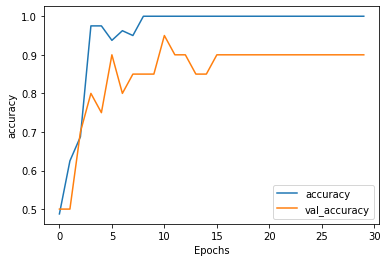

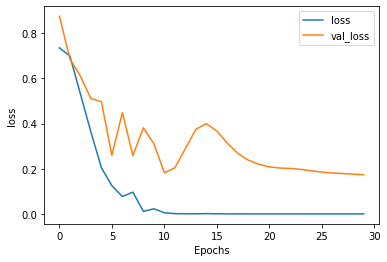

In [24]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#### A function to display all the images with their category and the confusion matrix : 

../img/resized/with_mask/image0.png
without_mask 81 %


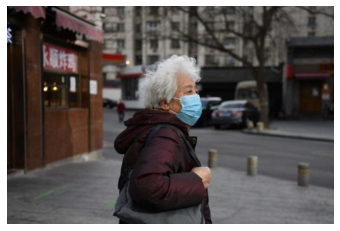

../img/resized/with_mask/image1.png
with_mask 100 %


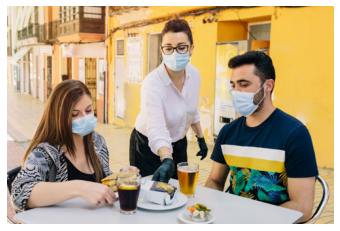

../img/resized/with_mask/image10.png
with_mask 100 %


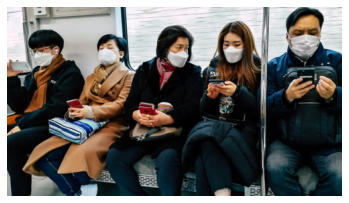

../img/resized/with_mask/image11.png
with_mask 100 %


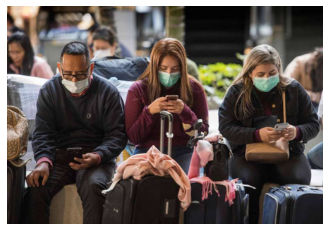

../img/resized/with_mask/image12.png
with_mask 68 %


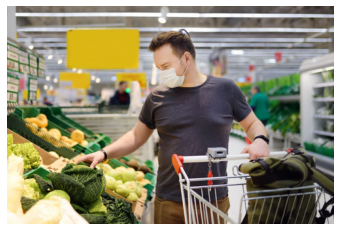

../img/resized/with_mask/image13.png
with_mask 100 %


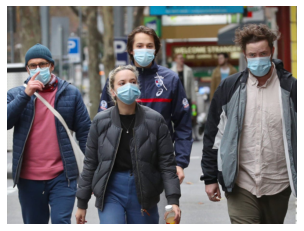

../img/resized/with_mask/image14.png
with_mask 100 %


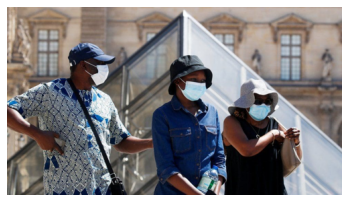

../img/resized/with_mask/image15.png
with_mask 100 %


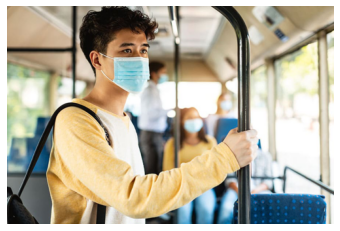

../img/resized/with_mask/image16.png


In [ ]:
def get_all_results():
    predictions = model.predict(validation_images)
    predicted_labels = []

    accuracy = 0

    for nb_image in range(len(validation_images)):

        fig, ax = plt.subplots()

        img = Image.open(validation_filenames[nb_image]) # We open the original image with  its original size
        print(validation_filenames[nb_image])
        we, he = img.size  # width and height of the image
        ax.imshow(img) # we display the image

        classes_predcitions = predictions[nb_image] # Predictions of the classes
        '''
        boxes_predictions = predictions[1][nb_image] # Predictions of the boxes

        # We transfrom the coordinate from [0,1] to [width image, height image]
        xmin = boxes_predictions[0] * we 
        ymin = boxes_predictions[1] * he
        xmax = boxes_predictions[2] * we 
        ymax = boxes_predictions[3] * he

        w = abs(xmax-xmin) # width of the box
        h = abs(ymax-ymin) # height of the box
        '''
        # Determination of the category : 
        probas = tf.nn.softmax(classes_predcitions)
        pourcentage = int(round(100*np.max(probas), 0))
        category_predicted = categories[np.argmax(probas)] 

        predicted_labels.append(np.argmax(probas))

        print(category_predicted, pourcentage, "%")


        if (np.argmax(probas) == validation_labels[nb_image]):
            accuracy = accuracy + 1

        #ax.add_patch(Rectangle((xmin,ymin), w, h,linewidth=1,edgecolor='r',facecolor='none')) # Drawing the box

        plt.axis('off') 
        plt.show()

    print("Accuracy : ", accuracy/len(validation_images) )
    print("Matrice de confusion :")
    print(metrics.confusion_matrix(validation_labels, predicted_labels))
    print(metrics.classification_report(validation_labels, predicted_labels,target_names=categories))
    

get_all_results()

#### A function to predict the result for a single image from the test data : 

In [ ]:
def prediction_function(file, mode):  # file = the name of the file (Note : it must be in the test data)
                                      # mode = 'category' if we want the category of the image
                                      # mode = 'probabilities' if we want the corresponging probabilities for the categories
    
    try:
        nb_image = list(validation_filenames).index(file)
        predictions = model.predict(validation_images)
      
        if mode=='category':
            category_predicted = categories[np.argmax(tf.nn.softmax(predictions[nb_image]))]
            print(" The predicted category is :  ", category_predicted )

        elif mode=='probabilities':
            proba_with_mask = int(round(100*np.max((tf.nn.softmax(predictions[nb_image]))[0]),0))
            proba_without_mask =  int(round(100*np.max((tf.nn.softmax(predictions[nb_image]))[1]),0))

            print(" Probability for the category with_mask     : " , proba_with_mask , "%")
            print(" Probability for the category without_mask  : " , proba_without_mask ,"%")
            

    except ValueError:
        print("Warning : the file name or the mode name contains an error.")


prediction_function('../img/resized/without_mask/image59.png',"probabilities")

### 2nd model : A model that takes the original images as input

In [ ]:
categories = ['with_mask', 'without_mask']

f = open ('annotations.json', "r")

data = json.loads(f.read())

images  = []          # The original images
targets = []          # The coordinates of the boxes
labels  = []          # The categories of the boxes
filenames = []        # The paths of the images 

width = 180
height = 180
num_classes = len(categories)



#### A function to load our data : 

In [ ]:
def load_data():
    global images, targets, labels, filenames, test_filenames,images_boxes
    
    images = []
    targets = []
    labels = []
    filenames = []
    images_boxes = []
    #test_filenames = []


    for i in data['data']:
        path = i['image']['path']
        we, he = Image.open(path).size # width and height of the original images
        img = image.load_img(path,target_size=(width,height)) # the original images with a size 180 by 180
        img_arr = image.img_to_array(img)

        for j in i['image']['boxes']: # We look at the boxes corresponding to each original image
            if(len(j)!=1):
                w = int(j['width'])
                h = int(j['height'])
                               
                category = j['category']
                
                name = j['name'].split('-')
                
                coords = name[2].split('x')

                xmin = float(coords[0]) 
                ymin = float(coords[1]) 
                xmax = float(xmin + w)  
                ymax = float(ymin + h)   

                path_box = j['path']
                
                width_box, height_box = Image.open(path_box).size
                image_selected = image.load_img(path_box,target_size=(width_box,height_box))
                image_selected_arr = image.img_to_array(image_selected)
                                                            
                images = images + [img_arr]
                x = (xmin/we, ymin/he, xmax/we, ymax/he) # we reduce the coordinates to the intervall [0,1]
                targets = targets + [x]
                labels = labels + [categories.index(category)]
                filenames.append(path)



load_data()
#print(images)
#print(targets)
#print(labels)
#print(filenames)

#### Separation of our data : train / test 

In [ ]:
# Number of total images = 100 
# Number of train images = 80
# Number of test images  = 20

train_images =  np.array(images[0:40]+images[50:90]) # In this model we are working with the orignial images
train_targets = np.array(targets[0:40]+targets[50:90])
train_labels =  np.array(labels[0:40]+labels[50:90])
train_filenames = np.array(filenames[0:40]+filenames[50:90])

validation_images =  np.array(images[40:50]+images[90:])
validation_targets = np.array(targets[40:50]+targets[90:])
validation_labels =  np.array(labels[40:50]+labels[90:])
validation_filenames = np.array(filenames[40:50]+filenames[90:])

In [ ]:
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)
base_layers = layers.Dropout(0.5)(base_layers)

classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='classi')(classifier_branch)  

locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='boundingbox')(locator_branch)

model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])


losses = {"classi":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "boundingbox":tf.keras.losses.MSE}
    
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])
model.summary()

In [ ]:
trainTargets = {
    "classi": train_labels,
    "boundingbox": train_targets
}
validationTargets = {
    "classi": validation_labels,
    "boundingbox": validation_targets
}

history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=32,
             epochs=30,
             shuffle=True,
             verbose=1)

In [ ]:
model.save("models/second_model")

In [ ]:
history.history.get("val_classi_accuracy")

In [ ]:
history.history.get("val_boundingbox_accuracy")

#### A function to display all the images with their category and the confusion matrix : 

In [ ]:
def get_all_results():
    predictions = model.predict(validation_images)
    predicted_labels = []

    accuracy = 0

    for nb_image in range(len(validation_images)):

        fig, ax = plt.subplots()

        img = Image.open(validation_filenames[nb_image]) # We open the original image with  its original size
        print(validation_filenames[nb_image])
        we, he = img.size  # width and height of the image
        ax.imshow(img) # we display the image

        classes_predcitions = predictions[0][nb_image] # Predictions of the classes
        
        boxes_predictions = predictions[1][nb_image] # Predictions of the boxes

        # We transfrom the coordinate from [0,1] to [width image, height image]
        xmin = boxes_predictions[0] * we 
        ymin = boxes_predictions[1] * he
        xmax = boxes_predictions[2] * we 
        ymax = boxes_predictions[3] * he

        w = abs(xmax-xmin) # width of the box
        h = abs(ymax-ymin) # height of the box
        
        # Determination of the category : 
        probas = tf.nn.softmax(classes_predcitions)
        pourcentage = int(round(100*np.max(probas), 0))
        category_predicted = categories[np.argmax(probas)] 

        predicted_labels.append(np.argmax(probas))

        print(category_predicted, pourcentage, "%")


        if (np.argmax(probas) == validation_labels[nb_image]):
            accuracy = accuracy + 1

        ax.add_patch(Rectangle((xmin,ymin), w, h,linewidth=1,edgecolor='r',facecolor='none')) # Drawing the box

        plt.axis('off') 
        plt.show()

    print("Accuracy : ", accuracy/len(validation_images) )
    print("Matrice de confusion :")
    print(metrics.confusion_matrix(validation_labels, predicted_labels))
    print(metrics.classification_report(validation_labels, predicted_labels,target_names=categories))
    

get_all_results()

### A function to predict the result for a single image from the test data :

In [ ]:
def prediction_function(file, mode):  # file = the name of the file (Note : it must be in the test data)
                                      # mode = 'category' if we want the category of the image
                                      # mode = 'probabilities' if we want the corresponging probabilities for the categories
    
    try:
        nb_image = list(validation_filenames).index(file)
        predictions = model.predict(validation_images)
      
        if mode=='category':
            category_predicted = categories[np.argmax(tf.nn.softmax(predictions[0][nb_image]))]
            print(" The predicted category is :  ", category_predicted )

        elif mode=='probabilities':
            proba_with_mask = int(round(100*np.max((tf.nn.softmax(predictions[0][nb_image]))[0]),0))
            proba_without_mask =  int(round(100*np.max((tf.nn.softmax(predictions[0][nb_image]))[1]),0))

            print(" Probability for the category with_mask     : " , proba_with_mask , "%")
            print(" Probability for the category without_mask  : " , proba_without_mask ,"%")
            

    except ValueError:
        print("Warning : the file name or the mode name contains an error.")


prediction_function('../img/resized/without_mask/image99.png',"probabilities")